# **NLP (Natural Language Processing) Proyecto para ML-OPS**

### 1.1 **Instalacion de API de kaggle de 50k reviews de peliculas**

In [142]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import  pyplot as plt # plotting


In [143]:
#Authenticate with kaggle API
import os
import kaggle
import shutil

def download_and_extract_kaggle_dataset():
    dataset_name = 'lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'
    download_path = r'C:\Proyectos\movies-proyect\data\raw_data'

    # Descargar y descomprimir el dataset
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)
    kaggle.api.dataset_metadata(dataset_name, path=download_path)

    # Listar las carpetas dentro de `raw_data`
    directories = [d for d in os.listdir(download_path) if os.path.isdir(os.path.join(download_path, d))]

    # Si hay una sola carpeta creada, la usamos
    if directories:
        dataset_dir = os.path.join(download_path, directories[0])
        
        # Mover los archivos a `raw_data`
        for filename in os.listdir(dataset_dir):
            shutil.move(os.path.join(dataset_dir, filename), download_path)

        # Eliminar la carpeta vacía
        shutil.rmtree(dataset_dir)
    else:
        print("No se encontró ninguna carpeta en raw_data")

if __name__ == "__main__":
    download_and_extract_kaggle_dataset()


Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
No se encontró ninguna carpeta en raw_data


In [144]:
#descargar csv del dataset instalado
df = pd.read_csv(r'C:\Proyectos\movies-proyect\data\raw_data\IMDB Dataset.csv')
df = df.iloc[:15000]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [145]:
#asegurarnos de el tamaño del dataset, en este caso debe ser de 50000 filas x 2 columnas
df.shape

(15000, 2)

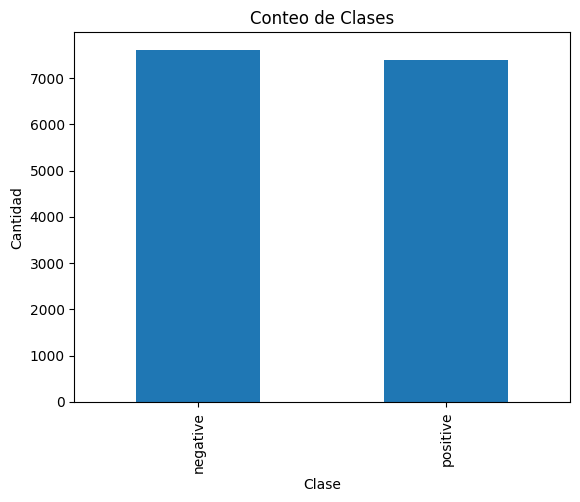

sentiment
negative    7609
positive    7391
Name: count, dtype: int64

In [146]:
#Visualizacion de distribucion de las clases
etiquetas_clases = {0: 'positive', 1: 'negative'}

df['sentiment'].value_counts().rename(index=etiquetas_clases).plot(kind='bar')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Conteo de Clases')
plt.show()
df['sentiment'].value_counts()

### 1.2 **Preprocesamiento de texto**

El preprocesamiento es crucial para limpiar y normalizar los datos de texto antes del análisis. Este paso implica varias subtareas:

- Tokenización: Dividir el texto en palabras individuales o tokens. Por ejemplo, «¡Hola mundo!» se convierte en - -[«Hola», «mundo», «!»].
- Minúsculas: Conversión de todos los caracteres a minúsculas para garantizar la uniformidad (por ejemplo, «Hola» y «hola» reciben el mismo tratamiento).

- Eliminación de signos de puntuación: Eliminación de los signos de puntuación, ya que a menudo no contribuyen al significado.
Eliminación de palabras vacías: Eliminación de palabras comunes como «y», «el», «es», que no aportan un significado significativo.

- Lematización: Conversión de palabras a su forma básica o raíz (por ejemplo, «correr» se convierte en «correr»).
Reducción: Similar a la lematización, pero suele ser más agresiva. Reduce las palabras a su raíz (por ejemplo, «running» se convierte en «run», «runner» en «run»).

Traducción realizada con la versión gratuita del traductor DeepL.com

### 1.2 **Remover palabras duplicadas**

In [147]:
df.duplicated().sum()

39

In [148]:
df.drop_duplicates(inplace=True)

### 1.2.1 **Minusculas**

In [149]:
#usar funcion .lower de python para pasar todas las palabras a mayusculas en el dataset
df['review'] = df['review'].str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### 1.2.2 **Remover cualquier etiquetas html del dataset**

In [150]:
#Importamos libreria para expresiones regulares
import re

#Funcion para remover etiqueta con expresion regular
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)

In [151]:
df['review']=df['review'].apply(remove_html_tags)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### 1.2.3 **Remover URLS**

In [152]:
#Funcion para recompilar con patrones las urls en el dataframe
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

In [153]:
df['review']=df['review'].apply(remove_url)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### 1.2.4 **GenZ Lingo treatment (procesar jergas)**

In [154]:
chat_word = {
    'afaik': 'as far as i know',
    'afk': 'away from keyboard',
    'asap': 'as soon as possible',
    'atk': 'at the keyboard',
    'atm': 'at the moment',
    'a3': 'anytime anywhere anyplace',
    'bak': 'back at keyboard',
    'bbl': 'be back later',
    'bbs': 'be back soon',
    'bfn': 'bye for now',
    'b4n': 'bye for now',
    'brb': 'be right back',
    'brt': 'be right there',
    'btw': 'by the way',
    'b4': 'before',
    'cu': 'see you',
    'cul8r': 'see you later',
    'cya': 'see you',
    'faq': 'frequently asked questions',
    'fc': 'fingers crossed',
    'fwiw': "for what its worth",
    'fyi': 'for your information',
    'gal': 'get a life',
    'gg': 'good game',
    'gn': 'good night',
    'gmta': 'great minds think alike',
    'gr8': 'great',
    'g9': 'genius',
    'ic': 'i see',
    'icq': 'i seek you',
    'ilu': 'i love you',
    'imho': 'in my honest humble opinion',
    'imo': 'in my opinion',
    'iow': 'in other words',
    'irl': 'in real life',
    'kiss': 'keep it simple stupid',
    'ldr': 'long distance relationship',
    'lmao': 'laugh my ass off',
    'lol': 'laughing out loud',
    'ltns': 'long time no see',
    'l8r': 'later',
    'mte': 'my thoughts exactly',
    'm8': 'mate',
    'nrn': 'no reply necessary',
    'oic': 'oh i see',
    'pita': 'pain in the ass',
    'prt': 'party',
    'prw': 'parents are watching',
    'qpsa': 'que pasa',
    'rofl': 'rolling on the floor laughing',
    'rofllol': 'rolling on the floor laughing out loud',
    'rotflmao': 'rolling on the floor laughing my ass off',
    'sk8': 'skate',
    'stats': 'your sex and age',
    'asl': 'age sex location',
    'thx': 'thank you',
    'ttyl': 'talk to you later',
    'u': 'you',
    'u2': 'you too',
    'u4e': 'yours for ever',
    'wb': 'welcome back',
    'wtf': 'what the fuck',
    'wtg': 'way to go',
    'wuf': 'where are you from',
    'tfw': 'that feeling when',
    'mfw': 'my face when',
    'mrw': 'my reaction when',
    'ifyp': 'i feel your pain',
    'tntl': 'trying not to laugh',
    'jk': 'just kidding',
    'idc': "i dont care",
    'ily': 'i love you',
    'imu': 'i miss you',
    'adih': 'another day in hell',
    'zzz': 'sleeping bored tired',
    'wywh': 'wish you were here',
    'time': 'tears in my eyes',
    'bae': 'before anyone else',
    'fimh': 'forever in my heart',
    'bsaaw': 'big smile and a wink',
    'bwl': 'bursting with laughter',
    'bff': 'best friends forever',
    'csl': "cant stop laughing"
}


In [155]:
#Funcion para filtrar jergas 
def short_conv(text):
    new_text = []
    for w in text.split():
        if w in chat_word:
            new_text.append(chat_word[w])
        else:
            new_text.append(w)
    return " ".join(new_text)


In [156]:
df['review']=df['review'].apply(short_conv)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend te...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the tears in my eyes ...",positive


### 1.2.5.  **Removiendo palabras menores a 3**

In [157]:
def filter_and_remove_short_words(df, column_name):
    # Aplica el filtro para remover palabras con 3 o menos letras
    df[column_name] = df[column_name].apply(lambda text: ' '.join([word for word in text.split() if len(word) >= 3]))
    return df

df = filter_and_remove_short_words(df, 'review')
df.head()


,review,sentiment
0,other reviewers mentioned that after watching ...,positive
1,wonderful little production. filming technique...,positive
2,thought this wonderful spend tears eyes summer...,positive
3,basically there's family where little (jake) t...,negative
4,"petter mattei's ""love tears eyes money"" visual...",positive


### 1.2.6.  **Removiendo Stop-Words**
Las «stop words» son palabras comunes en una lengua que suelen eliminarse porque tienen poco peso semántico y pueden entorpecer el análisis. Se trata de artículos (por ejemplo, «a», «el»), conjunciones (por ejemplo, «y», «o»), preposiciones (por ejemplo, «en», «sobre») y otros términos frecuentes que no contribuyen significativamente al significado de una frase. 

Al eliminar las palabras vacías, la atención se centra en palabras más significativas que representan mejor el contenido del texto, lo que mejora la eficacia y la precisión del análisis de textos y los modelos de aprendizaje automático.

In [158]:
import nltk
from nltk.corpus import stopwords

#Asegurarnos de que las stopwords estan instaladas, si no se descargaran automaticamente
try:
    stopwords.words('english')
    print('ya tienes stopwords')

except LookupError:
    nltk.download('stopwords')
    print('no tienes stopwords, \n descargando stopwords')


ya tienes stopwords


In [159]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [160]:
#Funcion para remover las stopWords
def remove_stopwords(text):
    new_text=[]
    for word in text.split():
        if word in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(word)
            
    x=new_text[:]
    new_text.clear()
    return " ".join(x)
'''
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words]
'''

"\ndef remove_stopwords(text):\n    stop_words = set(stopwords.words('english'))\n    return ' '.join([word for word in text.split() if word.lower() not in stop_words]\n"

In [161]:
df['review'] = df['review'].apply(remove_stopwords)
df.head()

,review,sentiment
0,reviewers mentioned watching episode hook...,positive
1,wonderful little production. filming technique...,positive
2,thought wonderful spend tears eyes summer wee...,positive
3,basically there's family little (jake) thinks...,negative
4,"petter mattei's ""love tears eyes money"" visual...",positive


### 1.2.7 **Remover puntuación**

In [162]:
import string

exclude=string.punctuation
#Funcion para remover la cualquier puntuacion en un texto '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punc(text):
    for char in exclude:
        text=text.replace(char,'')
    return text

In [163]:
df['review']=df['review'].apply(remove_punc)
df.head()

,review,sentiment
0,reviewers mentioned watching episode hook...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful spend tears eyes summer wee...,positive
3,basically theres family little jake thinks th...,negative
4,petter matteis love tears eyes money visually ...,positive


### 1.2.9 **Lematización**
La lematización reduce las palabras a su forma base o raíz, conocida como lema. A diferencia del stemming, que se limita a recortar las terminaciones de las palabras, la lematización tiene en cuenta el contexto y el análisis morfológico de las palabras, garantizando que éstas se transformen en formas base significativas. Por ejemplo, «running» se convierte en «run» y «better» en «good».

 Este proceso ayuda a normalizar las palabras, mejorando la precisión del análisis de textos al agrupar las distintas formas flexionadas de una palabra en un único elemento. La lematización es esencial para tareas como la clasificación de textos, el análisis de sentimientos y la recuperación de información, ya que mejora la calidad de las características extraídas del texto.

In [164]:
import spacy
import subprocess
import sys

# Nombre del modelo específico que deseas instalar
model_name = 'en_core_web_sm'

# Función para instalar el modelo de spaCy
def install_spacy_model(model_name):
    try:
        # Intentar cargar el modelo
        spacy.load(model_name)
        print(f"El modelo '{model_name}' ya está instalado.")
    except OSError:
        # Si el modelo no se encuentra, instalarlo
        print(f"El modelo '{model_name}' no está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        print(f"Modelo '{model_name}' instalado correctamente.")

# Instalar el modelo
install_spacy_model(model_name)

# Ahora puedes cargar el modelo y usarlo
nlp = spacy.load(model_name)

# Ejemplo de uso
def lemmatize_text(df, column_name):
    # Función para lematizar un texto completo
    def lemmatize_sentence(text):
        doc = nlp(text)
        # Une las palabras lematizadas
        return " ".join([token.lemma_ for token in doc])

    # Aplica la lematización a la columna del DataFrame
    df[column_name] = df[column_name].apply(lemmatize_sentence)
    
    return df


El modelo 'en_core_web_sm' ya está instalado.


In [165]:
# Aplica la función de lematización a la columna 'review'
df = lemmatize_text(df, 'review')
df.head()

,review,sentiment
0,reviewer mention watch episode hook ...,positive
1,wonderful little production filming technique ...,positive
2,think wonderful spend tear eye summer weeken...,positive
3,basically there s family little jake think t...,negative
4,petter matteis love tear eye money visually st...,positive


### 2. **Preparación del modelo para ML**

In [166]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,reviewer mention watch episode hook ...,1
1,wonderful little production filming technique ...,1
2,think wonderful spend tear eye summer weeken...,1
3,basically there s family little jake think t...,0
4,petter matteis love tear eye money visually st...,1


In [167]:
# Ruta del directorio
directorio = r'C:\Proyectos\movies-proyect\data\preprocessed_data'

# Nombre del archivo CSV
nombre_archivo = 'pre_processed.csv'

# Guardar el DataFrame en formato CSV
df.to_csv(os.path.join(directorio, nombre_archivo), index=False)

In [168]:
X = df.iloc[:,0:1]
y = df['sentiment']
X

,review
0,reviewer mention watch episode hook ...
1,wonderful little production filming technique ...
2,think wonderful spend tear eye summer weeken...
3,basically there s family little jake think t...
4,petter matteis love tear eye money visually st...
...,...
14995,bobcat goldthwait commend attempt something ...
14996,since day clarissa explain all I ve crush...
14997,travel couple horton hamiltonstumble onto town...
14998,film deeply disappointing wender displa...


In [169]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)
X_train.shape

(10472, 1)

In [170]:
# Definir los directorios para guardar los archivos CSV
directorios = {
    'X_train': r'C:\Proyectos\movies-proyect\data\train_data',
    'X_test': r'C:\Proyectos\movies-proyect\data\test_data',
    'y_train': r'C:\Proyectos\movies-proyect\data\train_data',
    'y_test': r'C:\Proyectos\movies-proyect\data\test_data'
}

# Asegurarse de que los directorios existen
for directorio in directorios.values():
    os.makedirs(directorio, exist_ok=True)

# Guardar los DataFrames en formato CSV en los respectivos directorios
X_train.to_csv(os.path.join(directorios["X_train"], 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(directorios["X_test"], 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(directorios["y_train"], 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(directorios["y_test"], 'y_test.csv'), index=False)

### 2.1 **Uso de TF-IDF (Transformación de palabras a numeros)** 

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

tfidf = TfidfVectorizer(min_df=2)

X_train_tfidf = tfidf.fit_transform(X_train['review']).toarray()
X_test_tfidf = tfidf.transform(X_test['review'])



## 3. **Entrenamiento del modelo**
En un problema de clasificación con **Random Forest**:

1. Entrenamiento:
    - Se entrena el modelo usando el conjunto de datos de entrenamiento, creando múltiples árboles con diferentes muestras de datos y características.

2. Predicción:
    - Para predecir la clase de una nueva muestra, cada árbol del bosque hace una predicción, y la clase con la mayoría de los votos es la predicción final del modelo.

3. Evaluación:
    - Se evalúa el rendimiento del modelo utilizando métricas como la precisión, el recall y la puntuación F1 para ver cómo se desempeña en datos no vistos.

In [172]:
rf = RandomForestClassifier()

rf.fit(X_train_tfidf,y_train)
y_pred = rf.predict(X_test_tfidf)

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.8389396302071731
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2247
           1       0.85      0.82      0.84      2242

    accuracy                           0.84      4489
   macro avg       0.84      0.84      0.84      4489
weighted avg       0.84      0.84      0.84      4489



In [173]:
from nbconvert import PythonExporter
import nbformat
import os

def obtener_nombre_archivo_unico(ruta_destino, nombre_base):
    """Genera un nombre de archivo único en la carpeta especificada."""
    i = 1
    nuevo_nombre = f'{nombre_base}.py'
    while os.path.exists(os.path.join(ruta_destino, nuevo_nombre)):
        nuevo_nombre = f'{nombre_base}{i}.py'
        i += 1
    return nuevo_nombre

# Especifica la ruta de la carpeta donde deseas guardar el archivo
ruta_destino = r'C:\Proyectos\movies-proyect\training\tests'
nombre_base = 'analyze_results'

# Asegúrate de que la carpeta existe
if not os.path.exists(ruta_destino):
    os.makedirs(ruta_destino)

# Lee el archivo .ipynb
with open(f'{nombre_base}.ipynb', 'r') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convierte el contenido del notebook a script Python
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Genera un nombre de archivo único
nombre_archivo = obtener_nombre_archivo_unico(ruta_destino, nombre_base)

# Guarda el script en la carpeta especificada
with open(os.path.join(ruta_destino, nombre_archivo), 'w') as f:
    f.write(script)

print(f"Archivo guardado como: {nombre_archivo}")

Archivo guardado como: analyze_results1.py
